# VPTD

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

## Distributions

Id_name               object
Extraversion         float64
Agreeableness        float64
Conscientiousness    float64
Neuroticism          float64
Openness             float64
SE                     int64
OE                     int64
dtype: object


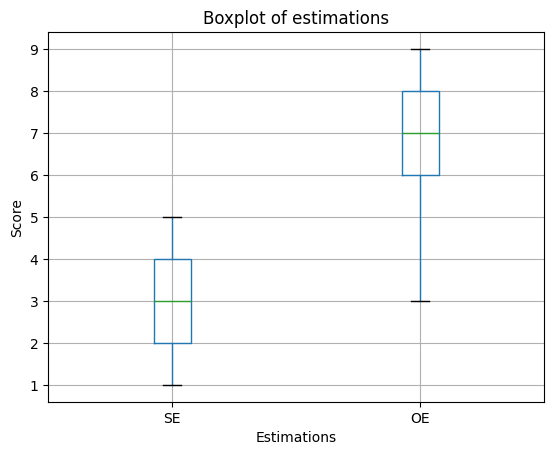

In [56]:
df = pd.read_csv("./Datasets/VPTD_Dataset.csv")

print(df.dtypes)

big_five_cols = [
    "Extraversion", "Agreeableness", "Conscientiousness",
    "Neuroticism", "Openness",
]

estimation_cols = ["SE", "OE"]

# boxplot
df.boxplot(column=big_five_cols)
plt.title("Boxplot of Traits")
plt.xlabel("Traits")
plt.ylabel("Score")
plt.show()

df.boxplot(column=estimation_cols)
plt.title("Boxplot of estimations")
plt.xlabel("Estimations")
plt.ylabel("Score")
plt.show()

### Histograms

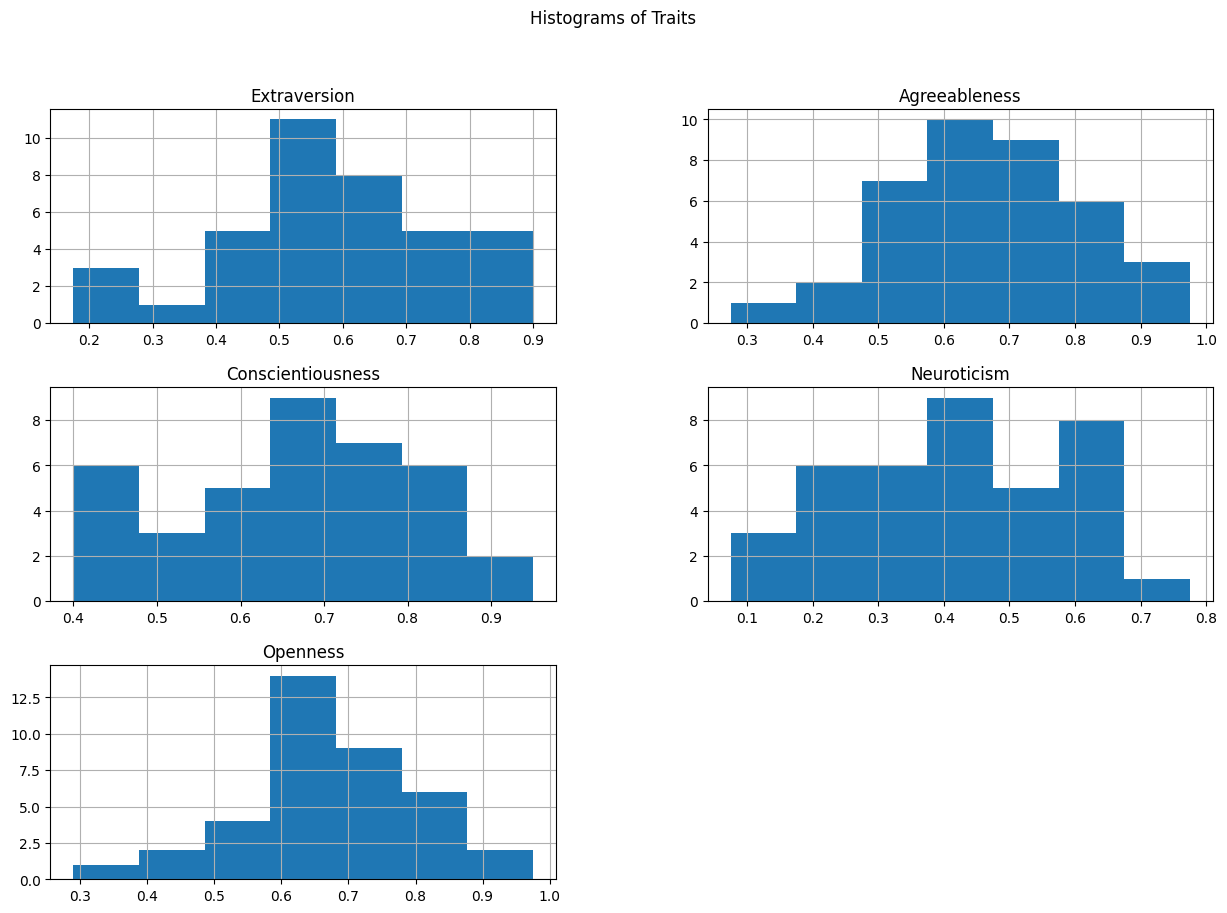

In [57]:
# histograms
df[big_five_cols].hist(bins=7, figsize=(15, 10))
plt.suptitle("Histograms of Traits")
plt.show()

# histograms
df[estimation_cols].hist(figsize=(15, 10))
plt.suptitle("Histograms of Estimations")
plt.show()

### Q-Q plot

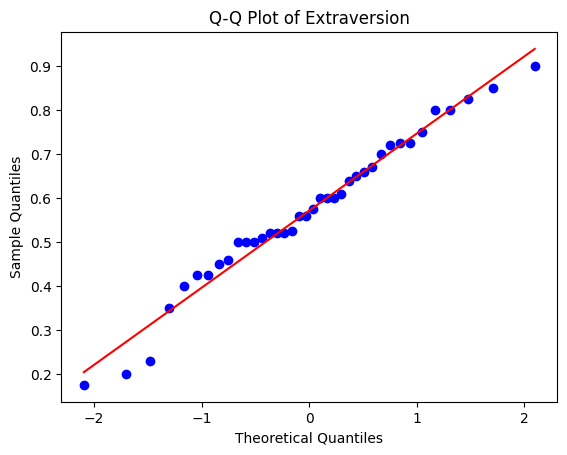

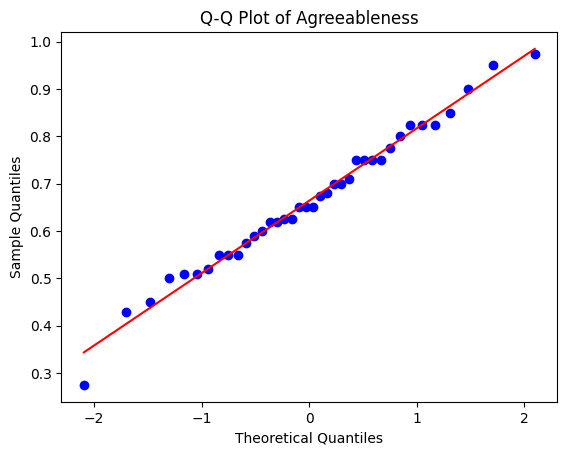

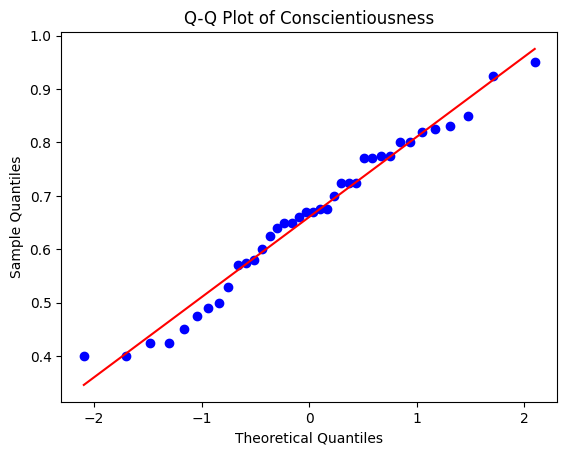

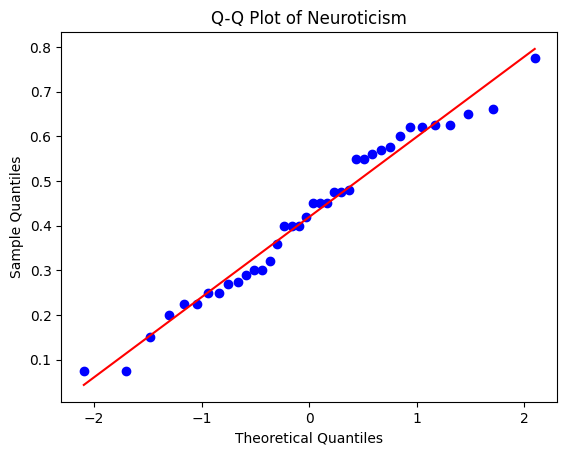

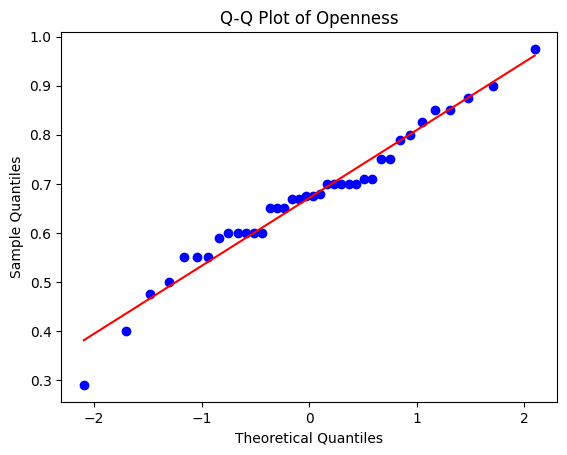

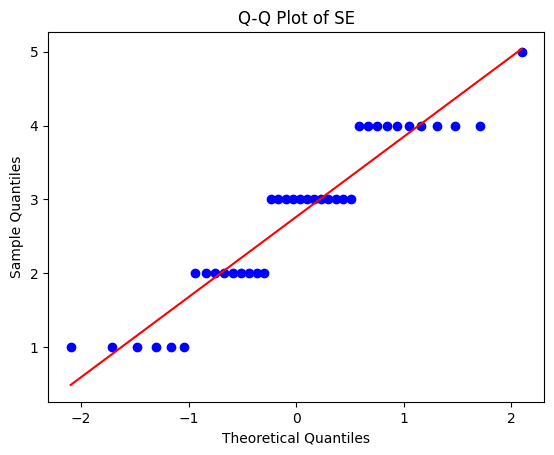

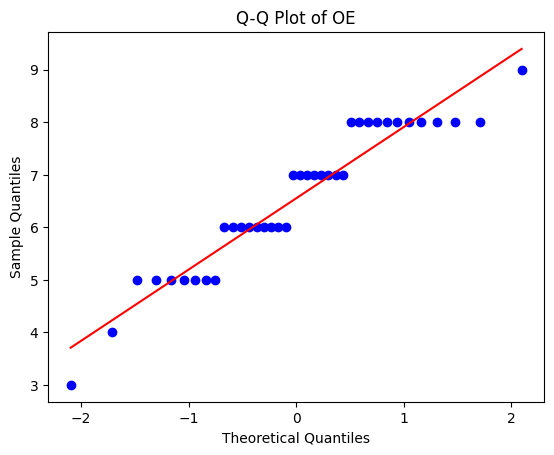

In [58]:
for var in big_five_cols+estimation_cols:
    # q-q plot
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {var}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()


As seen in the Q-Q plot, the traits distributions are approximately normal. We can use plenty of parametric methods for our statistical tests.

The estimation distributions are discrete. We'll use non-parametric methods for those.

## Hypothesis

In [59]:
print(df.dtypes)

Id_name               object
Extraversion         float64
Agreeableness        float64
Conscientiousness    float64
Neuroticism          float64
Openness             float64
SE                     int64
OE                     int64
dtype: object


Let's choose a statistical correction method.

"BH-FDR was generally the least conservative, while Bonferroni was the most conservative. Tukey’s HSD was more conservative than BH-FDR in several instances. These results highlight trade-offs between sensitivity and stringency across methods. We recommend BH-FDR for exploratory analysis, BY-FDR when dependency among tests is expected, and Bonferroni or Tukey’s HSD for analyses requiring strict control of false positives." (Bourget, G.).

*Bourget, G. Comparison of false discovery rate and familywise error rate methods for analyzing the removal of compounds of emerging concern in wastewater treatment plants. Discov Appl Sci 7, 745 (2025). https://doi.org/10.1007/s42452-025-07426-y*

As we're doing an exploratory analysis, we'll use the Benjamini-Hochberg correction for the set of hypotheses.

### Benjamini-Hochberg

BH is a statistical method to adjust the p-values when performing multiple hypothesis tests, aiming to control the False Discovery Rate.

This method is less conservative than the Bonferroni correction and it orders the p-values in ascending order, then applying a formula to determine a significance level adjusted to reduce the probability of false positives.

#### Comparison with other corrections

* **Less conservative than Bonferroni**: BH has a greater probability of detecting true positives (greater potency), but it can also have a greater number of false positives in comparison to Bonferroni.
* **Control the False Discovery Rate (FDR)**: Instead of controlling the probability of making a type I error, BH controls the expected proportion of false positives of all the rejected hypotheses.

#### When should it be used?

It's useful in analysis (such as the differential gene expression analysis) when there's a great number of hypotheses trying to be proved simultaneously.

It's used when the discovery of genuine effects is prioritized and we're willing to accept a certain level of false discoveries in exchange of a greater potency.

In [60]:
alpha = 0.05
tests_results = {}

### Defined hypotheses

* Is there a relationship between the self-estimation and the external estimation of the sales skills of an individual?
* Are there personality traits that predispose a person to overestimate/underestimate their sales skills?

#### Is there a relationship between the self-estimation and the external estimation of the sales skills of an individual?

SE and OE variables are not normally distributed. We'll use Kendall Tau correlation, as, to my understanding, Spearman doesn't handle ties well.

As the exploration is not restricted to a specific direction of association, the two-sided alternative hypothesis is used for the Kendall-Tau test.

In [61]:
significance_result = stats.kendalltau(df["SE"], df["OE"], method="auto", alternative="two-sided")
tests_results["hyp_1"] = {
    "pvalue": significance_result.pvalue,
    "tau": significance_result.correlation,
}

#### Are there personality traits that predispose a person to overestimate/underestimate their sales skills?

Let's define discrepancy as $\text{self-estimation} - \text{our estimation} = SE - OE$. A positive discrepancy means an overestimate; a negative means an underestimate.

Let's see the distribution of discrepancy.

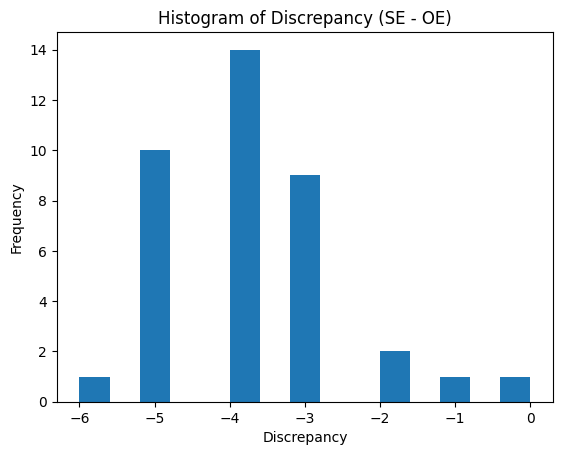

In [62]:
discrepancy = df["SE"] - df["OE"]
plt.hist(discrepancy, bins=15)
plt.title("Histogram of Discrepancy (SE - OE)")
plt.xlabel("Discrepancy")
plt.ylabel("Frequency")
plt.show()

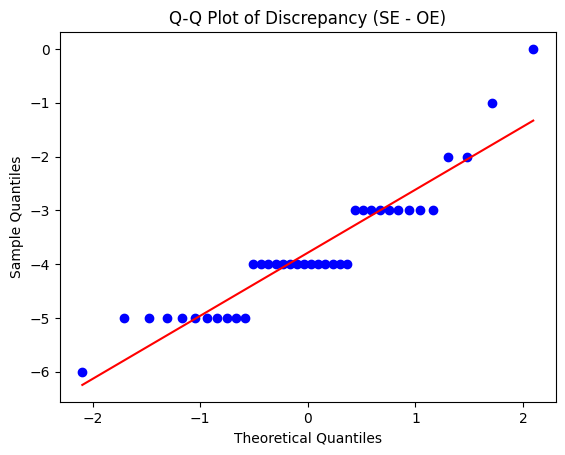

In [63]:
# Q-Q plot
stats.probplot(discrepancy, dist="norm", plot=plt)
plt.title("Q-Q Plot of Discrepancy (SE - OE)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

As its parent variables, discrepancy has a discrete distribution.

Given that the discrepancy variable only takes integer values and is tied, Kendall's Tau correlations were used to test the relationship between each personality trait and the discrepancy.

In [64]:
for var in big_five_cols:
    significance_result = stats.kendalltau(df[var], discrepancy, method="auto", alternative="two-sided")
    tests_results[f"hyp_{var}"] = {
        "pvalue": significance_result.pvalue,
        "tau": significance_result.correlation,
    }

### Results of the hypotheses

In [72]:
p_values = [result["pvalue"] for result in tests_results.values()]
ps_adjusted = stats.false_discovery_control(p_values, method='bh')
for i, key in enumerate(tests_results.keys()):
    tests_results[key]["pvalue_adjusted"] = ps_adjusted[i]
    print(f"{key}: p-value = {ps_adjusted[i]} | tau = {tests_results[key]['tau']}")
    if tests_results[key]["pvalue_adjusted"] < alpha:
        print(f"  -> Reject null hypothesis for {key}")
    else:
        print(f"  -> Fail to reject null hypothesis for {key}")

hyp_1: p-value = 0.0010770986578262814 | tau = 0.5055351682769138
  -> Reject null hypothesis for hyp_1
hyp_Extraversion: p-value = 0.13404152801422894 | tau = -0.23150776139827398
  -> Fail to reject null hypothesis for hyp_Extraversion
hyp_Agreeableness: p-value = 0.13404152801422894 | tau = 0.22919920174693015
  -> Fail to reject null hypothesis for hyp_Agreeableness
hyp_Conscientiousness: p-value = 0.13404152801422894 | tau = -0.2130093799922049
  -> Fail to reject null hypothesis for hyp_Conscientiousness
hyp_Neuroticism: p-value = 0.616694622722942 | tau = 0.06288340515786248
  -> Fail to reject null hypothesis for hyp_Neuroticism
hyp_Openness: p-value = 0.5421287972459025 | tau = -0.0955107563691663
  -> Fail to reject null hypothesis for hyp_Openness


### Plotting

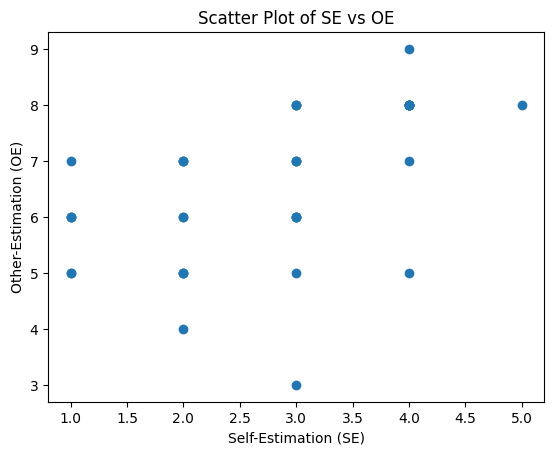

In [73]:
# SE vs OE
plt.scatter(df["SE"], df["OE"])
plt.title("Scatter Plot of SE vs OE")
plt.xlabel("Self-Estimation (SE)")
plt.ylabel("Other-Estimation (OE)")
plt.show()

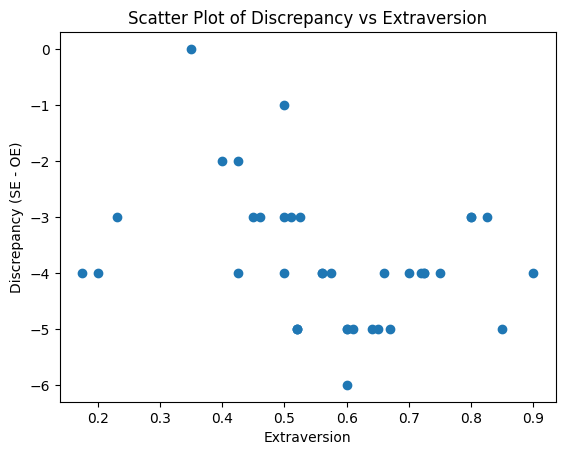

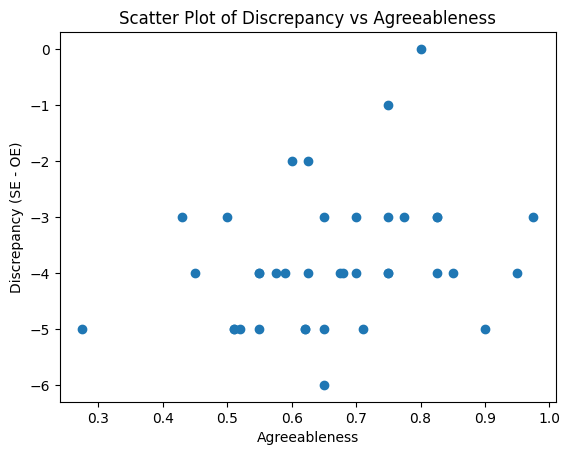

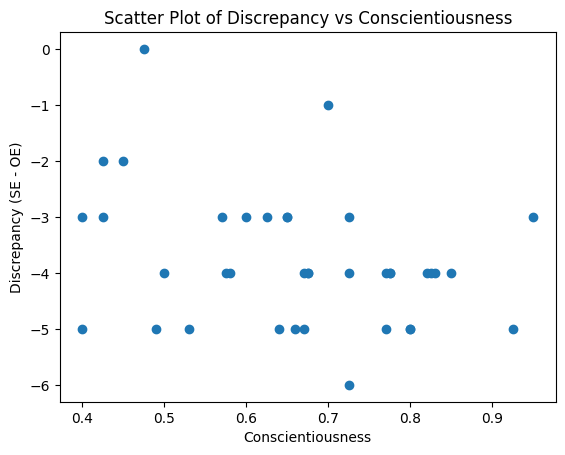

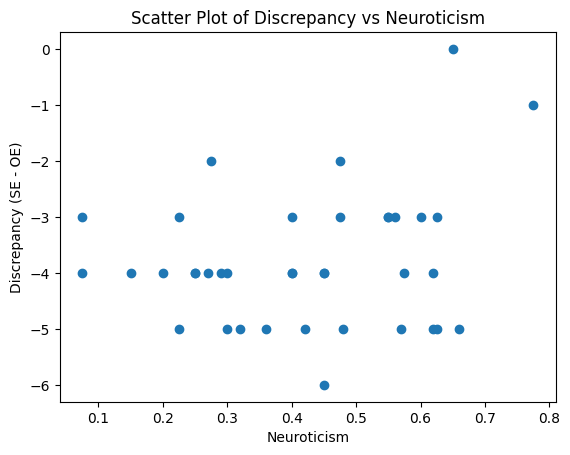

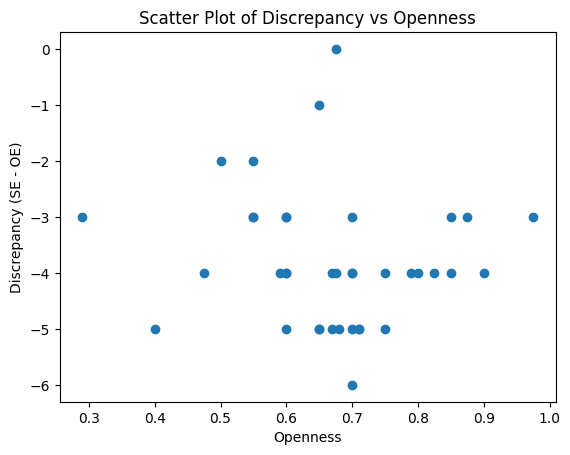

In [74]:
# Plot discrepancy vs each big five trait
for var in big_five_cols:
    plt.scatter(df[var], discrepancy)
    plt.title(f"Scatter Plot of Discrepancy vs {var}")
    plt.xlabel(var)
    plt.ylabel("Discrepancy (SE - OE)")
    plt.show()

## Conclusions

### Statistical correction approach

All p-values reported below were adjusted for multiple comparisons using the Benjamini-Hochberg procedure, considering the entire set of six tested hypotheses (SE–OE association and five personality-trait correlations).

### Relationship between self-estimation and external estimation of sales skills

Self-estimation (SE) and external estimation (OE) were found to be significantly, positively correlated (Kendall’s Tau = 0.51, BH-adjusted p-value = 0.0011). This moderate-to-strong correlation indicates that individuals' self-assessments of their sales skills tend to align with the external evaluations they receive.

### Personality traits and self-other estimation discrepancy

The discrepancy variable, defined as $SE - OE$, ranged from –6 to 0, and was analyzed for association with each of the Big Five personality traits (Extraversion, Agreeableness, Conscientiousness, Neuroticism, Openness) using Kendall’s Tau. None of the correlations reached statistical significance after Benjamini-Hochberg correction (all adjusted p-values > 0.13). Tau coefficients ranged from –0.23 to 0.23, indicating no meaningful relationship between personality and the tendency to over- or underestimate one’s sales abilities.



## Future work

There are some hypotheses that can't be proved using the VPTD dataset, but that would be useful for a real company.

### Hypotheses

* Are there personality traits that predict low/high external estimation of the sales skills of a person? (This one can be proved, but because of lack of time, we decided to discard it).
* Do people that overestimate/underestimate their sales skills are more probable to have lower sales performance (e.g., total sales)?
* Are there combinations of personality traits that are associated with higher/lower sales performance?
* How accurately can psychometrics and self-evaluations anticipate real sales performance?